### Imports and definitions

In [36]:
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
import numpy as np
from datetime import datetime
import pickle, sys, os, json
import pandas as pd
pd.set_option("display.max_columns", None)

import astropy.units as u
from astropy.coordinates import SkyCoord
from regions             import PointSkyRegion
from astropy.time        import Time
from scipy.stats         import chi2
from IPython.display     import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from gammapy.modeling.models import create_crab_spectral_model, SkyModel, LogParabolaSpectralModel
from gammapy.estimators      import FluxPointsEstimator, LightCurveEstimator
from gammapy.modeling        import Fit
from gammapy.datasets        import Datasets, SpectrumDataset
from gammapy.makers          import SpectrumDatasetMaker, WobbleRegionsFinder, ReflectedRegionsBackgroundMaker, SafeMaskMaker
from gammapy.maps            import MapAxis, RegionGeom, Map, TimeMapAxis
from gammapy.data            import DataStore

# import scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/lst1_systematics/scripts"))
import auxiliar  as aux
import documents as docs

# ============================ #
# dl3 path where dl3 and index files are
# dl3_dir = "/fefs/aswg/workspace/daniel.morcuende/data/real/DL3/Crab_performance/AllSkyMC_v0.9.9/intensity80/all_nodes/gh_eff_0.7_th_cont_0.7"
dl3_dir = "/fefs/aswg/workspace/juan.jimenez/data/lst1_systematics/dl3"

fname_dict = "objects/dict_spectrum.pkl"
# ============================ #

### Loading configuration files

In [2]:
# reading the configuration from the gammapy configuration file
target_name, n_off_regions, _e_reco, _e_true = docs.load_gammapy_analysis_configuration()

e_reco_min, e_reco_max, e_reco_bin_p_dec = _e_reco["min"], _e_reco["max"], _e_reco["bins_p_dec"]
e_true_min, e_true_max, e_true_bin_p_dec = _e_true["min"], _e_true["max"], _e_true["bins_p_dec"]


Gammapy analysis configuration:



{'target_name': 'crab',
 'n_off_regions': 1,
 'e_reco': {'min': 0.1, 'max': 50, 'bins_p_dec': 5},
 'e_true': {'min': 0.05, 'max': 200, 'bins_p_dec': 10}}

### Loading full datasets

In [3]:
# Opening all the dl3 data in a path
total_data_store = DataStore.from_dir(dl3_dir)

# Taking obs ids
obs_ids = total_data_store.obs_table["OBS_ID"].data
obs_ids = obs_ids[:]

# Then we get the observation information from the total data store
observations = total_data_store.get_observations(
    obs_ids,
    required_irf=["aeff", "edisp", "rad_max"]
)

# Defining target position and ON reion
target_position = SkyCoord.from_name(target_name, frame='icrs')
on_region = PointSkyRegion(target_position)

print(f'Total livetime of observations {total_data_store.obs_table["LIVETIME"].data.sum()/3600:.2f} h')
display(total_data_store.obs_table[:5])

Total livetime of observations 34.20 h


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes5,bytes5
2914,2020-11-18,03:43:34.195,2020-11-18,04:02:52.571,83.28333273835389,21.78656763343963,14.833854078422519,75.16614592157748,245.1184558734964,83.6333,22.0133,67319014.19521403,67320172.57145381,1158.378688097,1158.376239776611,1110.755623268583,0.9588881724795433,Crab,WOBBLE,1,LST-1,LST-1
2929,2020-11-19,01:41:13.092,2020-11-19,01:59:21.736,83.97361170669024,22.24478461554191,15.851370353506994,74.148629646493,110.69714313166,83.6333,22.0133,67398073.0916512,67399161.73551226,1088.646086215973,1088.643861055374,1006.045014654632,0.9241249542829353,Crab,WOBBLE,1,LST-1,LST-1
2930,2020-11-19,02:02:55.113,2020-11-19,02:22:43.858,83.26877531593242,21.78654578922968,11.225003496450213,78.77499650354979,126.6188631816417,83.6333,22.0133,67399375.11259389,67400563.8584733,1187.748401165009,1188.745879411697,1107.370648277967,0.9323276269551675,Crab,WOBBLE,1,LST-1,LST-1
2931,2020-11-19,02:24:41.948,2020-11-19,02:44:15.865,83.97560985781382,22.24446090923748,7.970256129037551,82.02974387096245,144.9828160578438,83.6333,22.0133,67400681.94754553,67401855.86502647,1172.932846069336,1173.917480945587,1097.560117693711,0.9357399457025957,Crab,WOBBLE,1,LST-1,LST-1
2932,2020-11-19,02:46:09.185,2020-11-19,03:05:51.191,83.27280949215712,21.77667796720452,7.156094817087634,82.84390518291237,188.4886603553226,83.6333,22.0133,67401969.18531418,67403151.19075465,1181.100458621979,1182.005440473557,1102.793449016734,0.9336999583451118,Crab,WOBBLE,1,LST-1,LST-1


### Defining all the energy axes

In [4]:
# ============================ #
# estimated energy axes
energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
# ============================ #
# estimated energy axes
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)
# ============================ #
# Energy for the spectrum
e_fit_min = energy_axis.edges[1].value
e_fit_max = energy_axis.edges[-1].value
e_fit_bin_p_dec = e_reco_bin_p_dec

# Just to have a separate MapAxis for spectral fit energy range
energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

# ============================ #
# Energy for the lightcurve
e_lc_min = energy_axis.edges[0]
e_lc_max = energy_axis.edges[-1]

print("Spectral fit will be done in energy edges:\n", energy_fit_edges)
print(f"\nLC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

Spectral fit will be done in energy edges:
 [ 0.15587755  0.24297811  0.37874832  0.5903836   0.9202755   1.4345029
  2.23606798  3.48552798  5.43315563  8.4690699  13.20137869 20.57798569
 32.07645997 50.        ] TeV

LC will be estimated from 0.1 TeV to 50.0 TeV


### Getting time parameters

In [5]:
# Get the GTI parameters of each observations to create time intervals for plotting LC
t_start  = []
t_stop   = []
tot_time = []

for obs in observations:
    gti = obs.gti
    
    t_start.append( gti.time_start[0])
    t_stop.append(  gti.time_stop[0])
    tot_time.append(gti.time_sum.value)

t_start  = np.sort(np.array(t_start))
t_stop   = np.sort(np.array(t_stop))
tot_time = np.array(tot_time)

t_start = Time(t_start)
t_stop  = Time(t_stop)

t_day = np.unique(np.rint(t_start.mjd))

# To make the range night-wise, keep the MJD range in half integral values
t_range = [Time([t-0.5, t+0.5], format="mjd", scale="utc") for t in t_day]

### We define the geometry regions in te sky and prepare the empty datasets and makers

In [6]:
# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_axis]
)

# creating an empty dataset
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_axis_true
)
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

### Now we analize the ON and OFF regions in the dataset and we store them in `datasets`, then the datasets can be stacked in a unique one

In [7]:
%%time
# The final object will be stored as a Datasets object
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(
        dataset=dataset_empty.copy(name=str(observation.obs_id)),
        observation=observation
    )
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    datasets.append(dataset_on_off) 

# Stacking all the datasets in one
stacked_dataset = Datasets(datasets).stack_reduce()
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : N9XDEtgO 

  Total counts                    : 743322 
  Total background counts         : 651764.00
  Total excess counts             : 91558.00

  Predicted counts                : 697543.00
  Predicted background counts     : 697543.00
  Predicted excess counts         : nan

  Exposure min                    : 5.26e+09 m2 s
  Exposure max                    : 3.42e+10 m2 s

  Number of total bins            : 14 
  Number of fit bins              : 14 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 19449.92

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 651764 
  Acceptance                      : 14 
  Acceptance off                  : 14 

CPU times: user 4min 9s, sys: 1min 14s, total: 5min 23s
Wall time: 5min 23s


### Then we define the model and set inside the dataset

In [8]:
# defining the model we want to fit and the starting values
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=1 * u.TeV,
)
# we will use the crab model in general
model = SkyModel(
    spectral_model=spectral_model, 
    name="crab"
)

# model.parameters["alpha"].frozen = True
# model.parameters["beta"].frozen  = True

# We set the model of all datasets to log parabola
stacked_dataset.models = model

### We fit the model with the stacked dataset

In [9]:
%%time
# Now we run the fit to extract the parameters of the model
fit = Fit()
result = fit.run(datasets=stacked_dataset)
best_fit_model = model.copy()

display(stacked_dataset.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,amplitude,3.4491e-11,cm-2 s-1 TeV-1,3.653e-13,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab,spectral,alpha,2.4498e+00,,9.909e-03,nan,nan,False,False,
crab,spectral,beta,1.1961e-01,,7.130e-03,nan,nan,False,False,


CPU times: user 1.38 s, sys: 24.1 ms, total: 1.41 s
Wall time: 1.4 s


### Then from the model and the data we can extract the flux points

In [10]:
%%time 
# then extracting the flux points from the data
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    source=target_name, 
    selection_optional="all"
)

# We apply the flux point estiation from the datasets
flux_points = fpe.run(datasets=stacked_dataset)
flux_points.to_table(sed_type="dnde", formatted=True)[:5]

CPU times: user 11.7 s, sys: 186 ms, total: 11.9 s
Wall time: 11.9 s


e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.195,0.156,0.243,1.349e-09,3.001e-11,3.007e-11,3.007e-11,1.409e-09,2015.826,44.898,127714.94396012776,21690.896,0.000,False,127715.0,True,0.200 .. 5.000,1275.911 .. 31398.162
0.303,0.243,0.379,5.319e-10,8.746e-12,8.745e-12,8.741e-12,5.494e-10,3732.352,61.093,46531.86450316603,16801.777,0.000,False,46532.0,True,0.200 .. 5.000,2374.851 .. 45665.611
0.473,0.379,0.590,2.042e-10,3.180e-12,3.182e-12,3.178e-12,2.106e-10,4211.022,64.892,22832.891019850296,11813.839,0.000,False,22833.0,True,0.200 .. 5.000,2725.644 .. 39063.287
0.737,0.590,0.920,7.271e-11,1.267e-12,1.269e-12,1.266e-12,7.526e-11,3412.281,58.415,11905.901980822586,7359.8647,0.000,False,11906.0,True,0.200 .. 5.000,2216.729 .. 27179.108
1.149,0.920,1.435,2.431e-11,5.124e-13,5.134e-13,5.113e-13,2.534e-11,2379.744,48.783,5815.948553438875,4113.9336,0.000,False,5816.0,True,0.200 .. 5.000,1541.949 .. 16888.400


### Then we can plot the SED

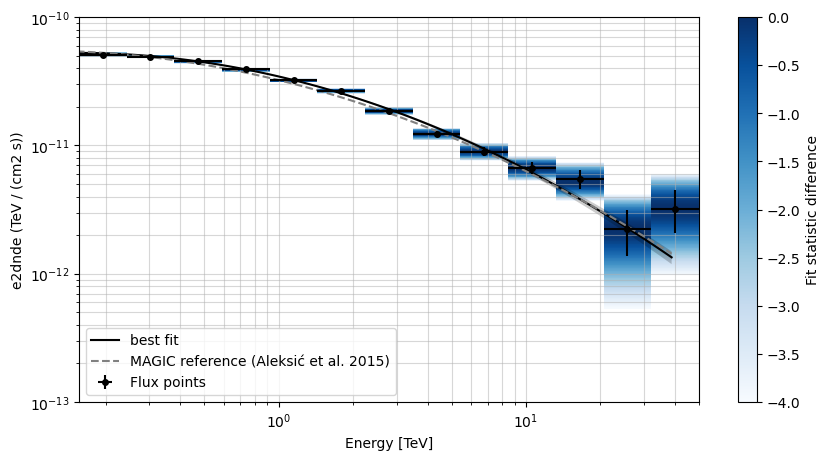

In [30]:
plot_kwargs = {
    "energy_bounds": [0.08, 40] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.TeV,
}

plt.figure(figsize=(10,5))

crab_magic_lp = create_crab_spectral_model("magic_lp")

best_fit_model.spectral_model.plot(
    ls="-", lw=1.5, color="k", label="best fit", **plot_kwargs
)
best_fit_model.spectral_model.plot_error(
    facecolor="k", alpha=0.2, **plot_kwargs
)
crab_magic_lp.plot(
    ls="--", lw=1.5, color="gray", label="MAGIC reference (Aleksić et al. 2015)", **plot_kwargs
)

flux_points.plot(sed_type="e2dnde", color="k", label="Flux points")
flux_points.plot_ts_profiles(sed_type="e2dnde")

plt.legend(loc=3)
plt.ylim([1e-13, 1e-10])
plt.grid(which="both", alpha=0.5)
plt.show()

In [ ]:
# def plot_sed(energy, xerr_left, xerr_right, e2dnde, e_e2dnde, E_e2dnde, ax, factor=0.4, kw=dict(), label=""):
    
#     # no quantities
#     energy = [_.value for _ in energy]
#     xerr_right, xerr_left = [_.value for _ in xerr_right], [_.value for _ in xerr_left]
#     e2dnde, e_e2dnde, E_e2dnde = [_.value for _ in e2dnde], [_.value for _ in e_e2dnde], [_.value for _ in E_e2dnde]
    
#     for i in range(len(energy)):
#         if str(e_e2dnde[i]) != "nan":
#             ax.errorbar(x=energy[i], y=e2dnde[i], xerr=([xerr_left[i]], [xerr_right[i]]), yerr=([abs(e_e2dnde[i])], [E_e2dnde[i]]), **kw)
#         else:
#             ax.errorbar(x=energy[i], y=e2dnde[i], xerr=([xerr_left[i]], [xerr_right[i]]), yerr=([0], [E_e2dnde[i]]), **kw)
#             E_delta = E_e2dnde[i] - e2dnde[i]
#             e_delta = e2dnde[i] - 10 ** (((1 + 1/factor)* np.log10(e2dnde[i]) - np.log10(e2dnde[i] + E_delta))*factor)
#             ax.errorbar(x=energy[i], y=e2dnde[i], xerr=0, yerr=e_delta, uplims=True, **kw)
#         if i == 0:
#             ax.errorbar([], [], 0, 0, **kw, label=label)

### Then once we have found the SED model we fix the alpha and beta parameters and let the amplitude as a free parameter

In [12]:
model.parameters["alpha"].frozen = True
model.parameters["beta"].frozen  = True

# Create the LC Estimator for each run
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source="crab", 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

# Assigning the fixed parameters model to each dataset
for data in datasets:
    data.models = model

### Then we run the lightcurve maker run-wise

In [13]:
%%time
print(f"LC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

lc_runwise = lc_maker_1d.run(datasets)
lightcurve = lc_runwise.to_table(sed_type="flux", format="lightcurve")

LC will be estimated from 0.1 TeV to 50.0 TeV
CPU times: user 2min 35s, sys: 650 ms, total: 2min 35s
Wall time: 2min 35s


### We calculate the mean flux and the statistical error

In [14]:
def weighted_average(table, sys_error=0):
    val = table["flux"]
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    return (val/uncertainty**2).sum() / (1/uncertainty**2).sum(), np.sqrt(1/np.sum(1/uncertainty**2))


mean_flux, mean_flux_err = weighted_average(lightcurve)

(4.697479669312898e-10, 3.435414196928583e-12)

### Calculating the $\chi^2$ and $p$ values

In [32]:
def calculate_chi2_pvalue(table, sys_error=0):
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    flux = table["flux"]
    mean_flux = (flux/uncertainty**2).sum() / (1/uncertainty**2).sum()
    mean_flux_err = np.sqrt(1/np.sum(1/uncertainty**2))
    print(f"Weighted mean flux: {mean_flux:.3e} +/- {mean_flux_err:.3e} cm-2 s-1")
    
    chi2_value = np.sum((table["flux"] - mean_flux)**2/uncertainty**2)
    ndf = len(table["flux"]) - 1
    pvalue = chi2.sf(x=chi2_value, df=ndf)
    print(f"Chi2: {chi2_value:.1f}, ndf: {ndf}, P-value: {pvalue:.2e}")
    return chi2_value, ndf, pvalue
    
calculate_chi2_pvalue(lightcurve, sys_error=0.0);

Weighted mean flux: 4.697e-10 +/- 3.435e-12 cm-2 s-1
Chi2: 212.0, ndf: 116, P-value: 1.34e-07


### Extracting the data from the table as arrays

In [79]:
time_min = Time(np.hstack(lightcurve["time_min"]), format='mjd').datetime
time_max = Time(np.hstack(lightcurve["time_max"]), format='mjd').datetime
delta_time  = time_max - time_min
time_center = time_min + delta_time / 2

flux_lst1 = np.hstack(lightcurve["flux"])
flux_stat_err_lst1 = np.hstack(lightcurve["flux_err"])

### The Crab Nebula reference from MAGIC

In [17]:
crab = create_crab_spectral_model("magic_lp")

crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)


flux_crab = crab.integral(e_lc_min, e_lc_max)
flux_crab_error = flux_crab * 0

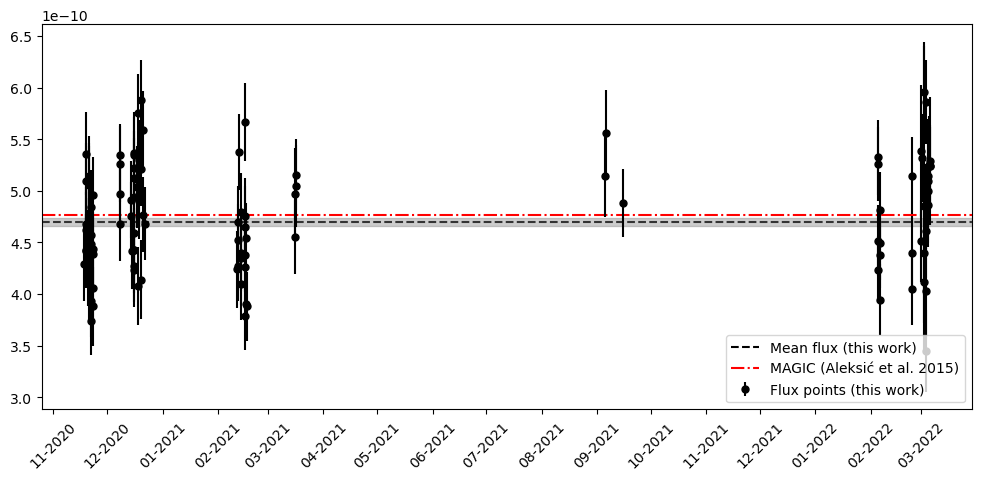

In [108]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.errorbar(time_center, flux_lst1, yerr=flux_stat_err_lst1, color="k", ls="", marker=".", ms=10, label="Flux points (this work)")
    
ax.axhline(mean_flux, ls="--", color="k", zorder=-1, label="Mean flux (this work)")
ax.axhspan(mean_flux - mean_flux_err, mean_flux + mean_flux_err, color='gray', alpha=0.4, zorder=-1)

ax.axhline(flux_crab.value, ls="-.", color="r", zorder=-1, label="MAGIC (Aleksić et al. 2015)")

# # plot the reference flux
# for label, model in reference_models.items():
    
#     integ_flux = model.integral(energy_edges[0], energy_edges[1])
#     ax.axhline(integ_flux, label=label, linestyle='--', lw=2, color='deeppink')
    
# energy_range = f'{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}'

# ax.set_title(f'Light curve of {source_name} ({energy_range})')
# ax.set_ylabel('Flux [cm$^{-2}$ s$^{-1}$]')
# ax.set_xlabel('Time [date]')

# # ax.set_xlim(18570, 18590)
# ax.legend()
# ax.set_yscale('linear')
# ax.grid()

ax.legend(loc=4)
ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%m-%Y'))
plt.xticks(rotation=45)


plt.show()

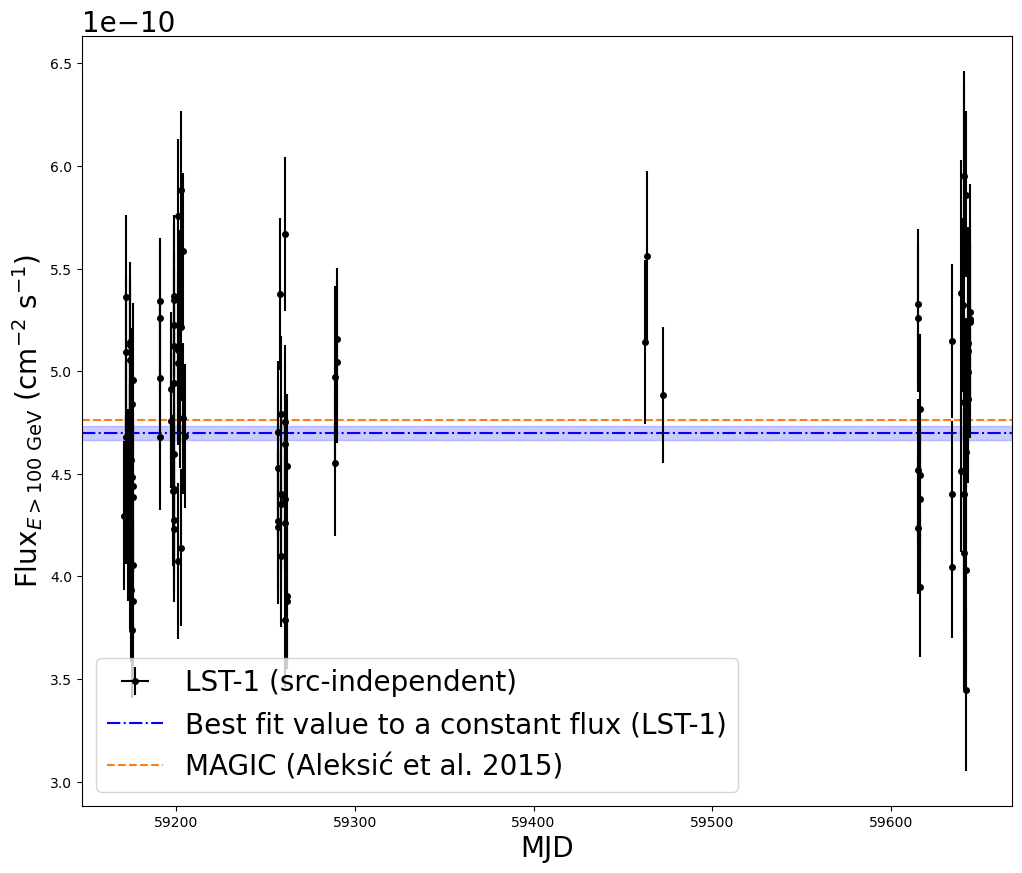

In [18]:
plt.figure(figsize=(12, 10))

TimeMapAxis.time_format = "mjd"

plt.axhline(
    mean_flux, c='b', ls='-.',
    label='Best fit value to a constant flux (LST-1)',
)

plt.axhspan(
    mean_flux - mean_flux_err, 
    mean_flux + mean_flux_err, 
    alpha=0.2, color='b'
)

# Plot Crab MAGIC reference
plt.axhline(
        flux_crab.to_value("cm-2 s-1"), 
        c='tab:orange',
        ls='--', 
        label='MAGIC (Aleksić et al. 2015)',
)
plt.axhspan(
        (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
        (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
        alpha=0.2, color='tab:orange'
)

ax = plt.gca()

lc_runwise.plot(
    ax = ax,
    sed_type="flux", 
    marker = "o",
    color='black',
    label='LST-1 (src-independent)',
)

ax.set_xlabel("MJD", fontsize=20)
ax.set_ylabel(r"Flux$_{E > 100 \rm{~GeV}}$ (cm$^{-2}$ s$^{-1}$)", fontsize=20)
ax.yaxis.get_offset_text().set_fontsize(20)
plt.yscale('linear')
# plt.ylim(0, 8e-10)

# Reorder labels in the legend
handles, labels = ax.get_legend_handles_labels()
order = [2, 0, 1]
plt.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order], 
    loc="lower left",
    fontsize=20
)

In [19]:
def unpack(data):
    return np.array([d[0][0][0] for d in data])
    
flux = (unpack(lc_runwise.flux.data) * lc_runwise.flux.unit).to("TeV / (cm2 s TeV)")
flux_err = (unpack(lc_runwise.flux_err.data) * lc_runwise.flux_err.unit).to("TeV / (cm2 s TeV)")
run_num = [(n) for n in observations.ids]

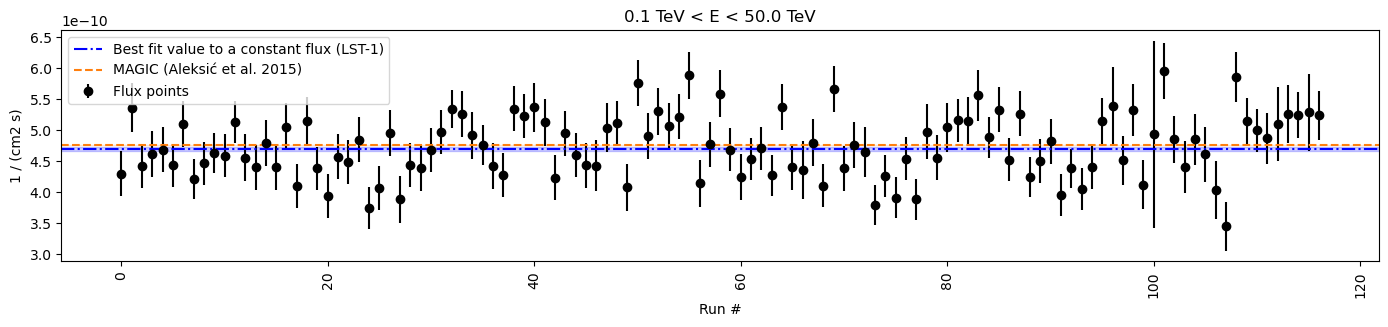

In [25]:
fig, ax = plt.subplots(figsize=(17,3))

# ax.axhline(flux_crab.to_value("cm-2 s-1"), c='red', ls='--', label='Crab (MAGIC, JHEAp 2015)')

ax.errorbar(np.arange(len(flux)), flux, yerr=flux_err, ls="", marker="o", color="k", label="Flux points")
# ax.errorbar(run_num, flux, yerr=flux_err, ls="", marker="o", color="k", label="Flux points")


plt.axhline(
    mean_flux, c='b', ls='-.',
    label='Best fit value to a constant flux (LST-1)',
)

plt.axhspan(
    mean_flux - mean_flux_err, 
    mean_flux + mean_flux_err, 
    alpha=0.2, color='b'
)

# Plot Crab MAGIC reference
plt.axhline(
        flux_crab.to_value("cm-2 s-1"), 
        c='tab:orange',
        ls='--', 
        label='MAGIC (Aleksić et al. 2015)',
)
plt.axhspan(
        (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
        (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
        alpha=0.2, color='tab:orange'
)


plt.xticks(rotation=90)
ax.legend()
ax.set_xlabel(f"Run #")
ax.set_ylabel(f"{flux.unit}")
ax.set_title(f"{e_lc_min:.1f} < E < {e_lc_max:.1f}")
plt.show()

In [21]:
dict_LC = {
    "run_number" : run_num,
    "flux" : flux,
    "e_flux" : flux_err,
}

obstable = total_data_store.obs_table.to_pandas()

In [22]:
time_start, time_stop, timedelta = [], [], []
zd, az = [], []
for run in dict_LC["run_number"]:
    _tab = obstable[obstable["OBS_ID"] == int(run)]
    tstart = datetime.fromisoformat(str(np.array(_tab["DATE-OBS"])[0] + b"T" + np.array(_tab["TIME-OBS"])[0])[2:-1])
    tstop  = datetime.fromisoformat(str(np.array(_tab["DATE-END"])[0] + b"T" + np.array(_tab["TIME-END"])[0])[2:-1])   
    time_start.append(tstart)
    time_stop.append(tstop)
    timedelta.append(tstop - tstart)
    zd.append(np.array(_tab["ZEN_PNT"])[0])
    az.append(np.array(_tab["AZ_PNT"])[0])
    
dict_LC["timestamp"] = np.array(time_start)
dict_LC["duration"]  = np.array(timedelta)
dict_LC["zd"] = np.array(zd) * u.deg
dict_LC["az"] = np.array(az) * u.deg

In [23]:
##################################
# save in a object

# Saving the objects
with open(fname_dict, 'wb') as f:
    pickle.dump(dict_LC, f, pickle.HIGHEST_PROTOCOL)